In [1]:
import numpy as np
import matplotlib.pyplot as plt
# set up bins
bins = np.linspace(8.5, 15.5, 7)
print(bins)
# Load the data table that contains the young nuclear Cluster
raw = np.loadtxt("/u/ryotainagaki/Desktop/YGCDataV2.dat", dtype ='object')

[ 8.5         9.66666667 10.83333333 12.         13.16666667 14.33333333
 15.5       ]


In [2]:
new_arr = raw.astype('float64')

In [3]:
new_arr = np.hstack((new_arr, np.array([np.ones(len(new_arr))]).transpose()))

In [4]:
# Load in WR Stars and Other stars that could be Young Stars (have P(Young) associated explicitly in
# Tuan et. al 2013)
# Exclude star name and uncorrected K' values. Also not include the Field (e.g. C, NW)
raw2 = np.loadtxt("/u/ryotainagaki/Desktop/CompletenessSim.dat", dtype ='object')[:, 2:-1].astype('float64')

In [5]:
new_arr = np.vstack((new_arr, raw2))
from astropy.table import Table
YGC_Table = Table(new_arr , names = ["KpErr", "Kp", "PYoung"])
# As in Lu et al 2013 we do not consider stars of >=15.5 K' magnitude
YGC_Table = YGC_Table[np.where(YGC_Table['Kp']<15.5)[0]]

Before I dive into functions (had to debug and check), I shall confirm that neither 'Kp' values nor the 'Kp' +/- '$\sigma_{Kp}$' values are going to be clean integers. This will allow us to use the less than or equals to inequalities when dealing with bins. (generally numpy bins are not inclusive intervals).

In [6]:
np.where([x==int(y) for x, y in zip(YGC_Table['Kp'], YGC_Table['Kp'])])

(array([148]),)

In [7]:
YGC_Table[148]

KpErr,Kp,PYoung
float64,float64,float64
0.1,15.0,0.12


In [8]:
np.where([x - y==int(x - y) for x, y in zip(YGC_Table['Kp'], YGC_Table['KpErr'])])

(array([72]),)

In [9]:
np.where([x + y==int(x + y) for x, y in zip(YGC_Table['Kp'], YGC_Table['KpErr'])])

(array([151]),)

Hence, I don't need to worry about more weird cases of finding maximum possible stars in a bin.

In [10]:
np.where(YGC_Table['KpErr']>=1)

(array([], dtype=int64),)

Hence, I do not have to worry about the equals to part of the LEQ operation misassigning a Kp to a bin.

Now I try to calculate the minimum bound of elements in the $K_p$ bins by eliminating elements whose $K_p - \sigma_{K_p}$ or $K_p + \sigma_{K_p}$ can be outside of the bin $K_p$ is in.

In [11]:
min_num_in_bins=[0 for x in bins]
# For this snippet of code, I shall assume that the bin width is 1.
def lower_bound(bin_number, bin_width=1):
    """
    Find a lower bound for the number of young stars in the K' bin.
    """
    # Before applying the minimization, how many stars are in the bin?
    tab_slice = YGC_Table[np.where(((YGC_Table['Kp'] - (10 + bin_width * bin_number)) < 1) & 
                                   ((YGC_Table['Kp'] - (10 + bin_width * bin_number)) >= 0) &
                                   (YGC_Table['PYoung'] >= 1.0))[0]]
    # Now, which stars, even after applying error in K_p, would still be inside of the bin
    min_num_in_bins[bin_number] += len(np.where(((tab_slice['Kp'] - tab_slice['KpErr'] -
                                                  (10 + bin_width * bin_number)) < 1) &
                                                ((tab_slice['Kp'] - tab_slice['KpErr'] -
                                                  (10 + bin_width * bin_number)) >= 0) &
                                                ((tab_slice['Kp'] + tab_slice['KpErr'] -
                                                  (10 + bin_width * bin_number)) < 1) &
                                                ((tab_slice['Kp'] + tab_slice['KpErr'] -
                                                  (10 + bin_width * bin_number)) >= 0))[0])
for x in map(lower_bound, range(len(bins))):
    print(x)

None
None
None
None
None
None
None


In [12]:
min_num_in_bins

[8, 6, 13, 15, 13, 9, 0]

Now I try to calculate the maximum bound of the number of stars in each bin x by including elements whose $K_p - \sigma_{K_p}$ or $K_p + \sigma_{K_p}$ can be included in the bin x is in. Also all elements whose $K_p$ is in the bin x are kept in the bin.

In [13]:
max_num_in_bins = [0 for x in bins]
def grouper_2(bin_number, bin_width=1):
    # print(10.5 + bin_width * bin_number)
    tab_slice = YGC_Table[np.where(((YGC_Table['Kp'] - (10.0 + bin_width * bin_number)) < 1) &
                                   ((YGC_Table['Kp'] - (10.0 + bin_width * bin_number)) >= 0) &
                                   (YGC_Table['PYoung'] > 0))[0]]
    others_to_check = YGC_Table[np.where((((YGC_Table['Kp'] - (10.0 + bin_width * bin_number)) >= 1) |
                                         ((YGC_Table['Kp'] - (10.0 + bin_width * bin_number)) < 0)) &
                                         (YGC_Table['PYoung'] > 0))][0]
    # print(len(tab_slice))
    # print(len(others_to_check))
    # print("Bin", bin_number)
    max_num_in_bins[bin_number] += (len(tab_slice) +
                                    len(np.where((((others_to_check['Kp'] - others_to_check['KpErr'] -
                                                    (10.0 + bin_width * bin_number)) >=  0) &
                                                  ((others_to_check['Kp'] - others_to_check['KpErr'] -
                                                    (10.0 + bin_width * bin_number)) <  1)) |
                                                 (((others_to_check['Kp'] + others_to_check['KpErr'] -
                                                      (10.0 + bin_width * bin_number)) >=  0) &
                                                  ((others_to_check['Kp'] + others_to_check['KpErr'] -
                                                    (10.0 + bin_width * bin_number)) <  1)))[0]))
leng = (len(bins))
for x in range(leng):
    
    grouper_2(x)

In [14]:
max_num_in_bins

[8, 9, 18, 17, 31, 60, 0]

[0.0, 4.42, 6.279999999999999, 16.57, 20.720000000000002, 31.740000000000013, 0.0]


Text(0.5, 1.0, '$K_p$ band Luminosity function')

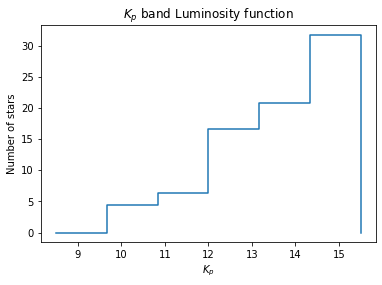

In [15]:
def add_by_one_x(x):
    """Increment x-1th term in binned counts"""
    if not x:
        return
    # print(binned_counts_help[x])
    binned_counts[binned_counts_help[x]-1] += min(YGC_Table['PYoung'][x], 1.0)

binned_counts_help = np.digitize(YGC_Table['Kp'][np.where((YGC_Table['PYoung'] > 0) & 
                                                          (YGC_Table['Kp'] <= 15.5))[0]], bins)
binned_counts = [0.0 for x in bins]
# print(list(range(0, len(binned_counts_help))))
for x in range(0, len(binned_counts_help)):
    add_by_one_x(x)
print(binned_counts)
plt.step(bins, binned_counts, where='post', data=None)
plt.xlabel("$K_p$")
plt.ylabel("Number of stars")
plt.title("$K_p$ band Luminosity function")

In [16]:
binned_counts

[0.0,
 4.42,
 6.279999999999999,
 16.57,
 20.720000000000002,
 31.740000000000013,
 0.0]

In [17]:
new_arr[:, 1]

array([14.39, 14.96, 14.82, 15.27, 15.41, 14.51, 14.42, 15.31, 13.88,
       12.22, 13.69, 14.88, 13.22, 12.67, 14.29, 15.05, 13.63, 12.88,
       12.65, 13.58, 14.75, 11.47, 14.11, 10.75, 13.32, 12.09, 12.02,
       15.42, 11.23, 15.38, 10.64, 12.92, 13.34, 12.5 , 14.07, 13.07,
       14.99, 15.25, 12.13, 15.15, 13.46, 14.21, 12.3 , 10.6 , 13.72,
       12.21, 11.28, 14.57, 12.28, 13.7 , 14.24, 13.82, 11.09, 13.33,
       12.46, 11.75, 12.1 , 11.05, 13.83, 13.98, 14.46, 15.43, 13.23,
       12.98, 14.76, 14.35, 14.36, 15.48, 15.43, 15.45, 15.3 , 15.4 ,
       15.07, 15.28, 15.14, 15.38, 15.07, 14.46, 15.46, 15.36, 15.41,
       15.34, 15.27, 15.26, 15.31, 13.45, 15.47, 15.25, 15.4 , 14.9 ,
       15.22, 15.34, 14.92, 15.37, 15.31, 14.64, 15.3 , 15.13, 15.16,
       15.48, 15.24, 15.32, 15.45, 15.36, 15.36, 15.02, 14.8 , 14.8 ,
       15.25, 15.48, 15.35, 15.35, 15.37, 14.38, 14.2 , 14.76, 15.16,
       15.1 , 12.97, 14.62, 15.19, 15.48, 15.45, 15.48, 15.1 , 15.43,
       14.66, 15.47,

In [18]:
np.digitize(new_arr[:, 1], bins)

array([6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 4, 5, 6, 3,
       5, 2, 5, 4, 4, 6, 3, 6, 2, 4, 5, 4, 5, 4, 6, 6, 4, 6, 5, 5, 4, 2,
       5, 4, 3, 6, 4, 5, 5, 5, 3, 5, 4, 3, 4, 3, 5, 5, 6, 6, 5, 4, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 5, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 3,
       3, 1, 4, 2, 3, 2, 5, 4])

Now, introducing the BPASS Cluster.

In [ ]:
from spisea import synthetic
BPASS_iso = synthetic.Isochrone_Binary(6.6, 2.7, 8096, 0.0, min_mass = 1, max_mass = 150, filters=['nirc2,Kp'])

/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /g/lu/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /g/lu/models/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/u/ryotainagaki/Desktop/PyPopStar/spisea/evolution.py:1792: RuntimeWarning: overflow encountered in power
  (1 / cs.au) * un.m)
/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = geta

Changing to logg=3.50 for T= 26185 logg=3.00
Changing to T= 50000 for T=167251 logg=5.76
Changing to logg=5.00 for T=167251 logg=5.76
Changing to T= 50000 for T=120080 logg=5.33
Changing to logg=5.00 for T=120080 logg=5.33
Changing to logg=4.00 for T= 32831 logg=3.90
Changing to T= 50000 for T=118484 logg=5.31
Changing to logg=5.00 for T=118484 logg=5.31
Changing to T= 50000 for T= 95457 logg=4.73
Changing to logg=5.00 for T= 95457 logg=4.73
Changing to T= 50000 for T=116161 logg=5.12
Changing to logg=5.00 for T=116161 logg=5.12
Changing to logg=3.00 for T= 19983 logg=2.46
Changing to T= 50000 for T=118664 logg=5.16
Changing to logg=5.00 for T=118664 logg=5.16
Changing to T= 50000 for T=168531 logg=5.77
Changing to logg=5.00 for T=168531 logg=5.77
Changing to logg=3.00 for T= 25165 logg=2.92
Changing to logg=4.00 for T= 33667 logg=3.84
Changing to T= 50000 for T=112365 logg=5.21
Changing to logg=5.00 for T=112365 logg=5.21
Changing to T= 50000 for T=108808 logg=5.16
Changing to logg=5.

Changing to T= 50000 for T=100028 logg=4.85
Changing to logg=5.00 for T=100028 logg=4.85
Changing to logg=4.00 for T= 31570 logg=3.96
Changing to logg=4.00 for T= 31570 logg=3.96
Changing to logg=4.00 for T= 33681 logg=3.69
Changing to logg=3.00 for T= 20281 logg=2.26
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 32586 logg=3.87
Changing to logg=4.00 for T= 31948 logg=3.49
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to T= 50000 for T=108323 logg=5.14
Changing to logg=5.00 for T=108323 logg=5.14
Changing to logg=4.00 for T= 31948 logg=3.49
Changing to logg=4.00 for T= 33681 logg=3.69
Changing to logg=4.00 for T= 33052 logg=3.78
Changing to T= 50000 for T=113138 logg=5.07
Changing to logg=5.00 for T=113138 logg=5.07
Changing to T= 50000 for T=120312 logg=5.33
Changing to logg=5.00 for T=120312 logg=5.33
Changing to logg=4.00 for T= 33107 logg=3.87
Changing to logg=2.50 for T= 18712 logg=2.33
Changing to lo

Changing to logg=4.00 for T= 33602 logg=3.87
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 32586 logg=3.87
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 33331 logg=3.86
Changing to T= 50000 for T=113138 logg=5.07
Changing to logg=5.00 for T=113138 logg=5.07
Changing to logg=4.00 for T= 31570 logg=3.96
Changing to logg=2.50 for T= 14718 logg=1.87
Changing to T= 50000 for T=113138 logg=5.07
Changing to logg=5.00 for T=113138 logg=5.07
Changing to T= 50000 for T=115226 logg=5.10
Changing to logg=5.00 for T=115226 logg=5.10
Changing to logg=4.00 for T= 31948 logg=3.49
Changing to logg=4.00 for T= 33681 logg=3.69
Changing to logg=3.50 for T= 28996 logg=2.98
Changing to logg=4.00 for T= 33052 logg=3.78
Changing to logg=4.00 for T= 33681 logg=3.69
Changing to logg=4.00 for T= 32586 logg=3.87
Changing to logg=3.50 for T= 29626 logg=3.03
Changing to logg=3.50 for T= 28913 logg=3.21
Changing to logg=4.00 for T= 31948 logg=3.49
Changing to l

Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 33681 logg=3.69
Changing to T= 50000 for T=115226 logg=5.10
Changing to logg=5.00 for T=115226 logg=5.10
Changing to logg=4.00 for T= 33681 logg=3.69
Changing to logg=2.50 for T= 14718 logg=1.87
Changing to logg=4.00 for T= 33602 logg=3.87
Changing to logg=4.00 for T= 33602 logg=3.87
Changing to logg=4.00 for T= 32586 logg=3.87
Changing to logg=4.00 for T= 33681 logg=3.69
Changing to logg=4.00 for T= 33042 logg=3.91
Changing to logg=3.50 for T= 29307 logg=3.25
Changing to logg=4.00 for T= 33052 logg=3.78
Changing to T= 50000 for T=115226 logg=5.10
Changing to logg=5.00 for T=115226 logg=5.10
Changing to T= 50000 for T=120468 logg=5.34
Changing to logg=5.00 for T=120468 logg=5.34
Changing to T= 50000 for T=158511 logg=5.72
Changing to logg=5.00 for T=158511 logg=5.72
Changing to T= 50000 for T=113138 logg=5.07
Changing to logg=5.00 for T=113138 logg=5.07
Changing to logg=3.00 for T= 24796 logg=2.88
Changing to log

Changing to logg=4.00 for T= 31570 logg=3.96
Changing to logg=4.00 for T= 33052 logg=3.78
Changing to logg=4.00 for T= 33052 logg=3.78
Changing to logg=4.00 for T= 33602 logg=3.87
Changing to logg=4.00 for T= 33558 logg=3.68
Changing to logg=3.00 for T= 19364 logg=2.29
Changing to logg=4.00 for T= 33052 logg=3.78
Changing to T= 50000 for T=126223 logg=5.31
Changing to logg=5.00 for T=126223 logg=5.31
Changing to logg=4.00 for T= 31570 logg=3.96
Changing to logg=4.00 for T= 31948 logg=3.49
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 31948 logg=3.49
Changing to logg=4.00 for T= 31570 logg=3.96
Changing to logg=4.00 for T= 33107 logg=3.87
Changing to logg=4.00 for T= 32208 logg=3.96
Changing to logg=4.00 for T= 33107 logg=3.87
Changing to T= 50000 for T=116931 logg=5.28
Changing to logg=5.00 for T=116931 logg=5.28
Changing to logg=3.00 for T= 24139 logg=2.65
Changing to logg=4.00 for T= 31948 logg=3.49
Changing to 

In [ ]:
from spisea import imf, ifmr
custom_IMF = imf.imf.IMF_broken_powerlaw(np.array([1, 200]), np.array([-1.7]),
                                         multiplicity=imf.multiplicity.MultiplicityResolvedDK())
BPASS_Cluster = synthetic.Binary_Cluster(BPASS_iso, custom_IMF, 20000, ifmr=ifmr.IFMR_Spera15())

In [ ]:
def add_by_one_x(x):
    """Increment x-1th term in binned counts"""
    if not x:
        return
    # print(binned_counts_help[x])
    binned_counts_sim[binned_counts_help[x]-1] += min(YGC_Table['PYoung'][x], 1.0)

binned_counts_help = np.digitize(YGC_Table['Kp'][np.where((YGC_Table['PYoung'] > 0) & 
                                                          (YGC_Table['Kp'] <= 15.5))[0]], bins)
binned_counts_sim = [0.0 for x in bins]
# print(list(range(0, len(binned_counts_help))))
for x in range(0, len(binned_counts_help)):
    add_by_one_x(x)
print(binned_counts_sim)
plt.figure().set_figheight(4 + 4*np.sqrt(5))
plt.figure().set_figwidth(8)
plt.hist(BPASS_Cluster.star_systems['m_nirc2_Kp'], bins, histtype = 'step', density=True, align = 'mid',
         label='BPASS Cluster star systems')
plt.step(bins, binned_counts_sim/np.sum(binned_counts_sim), where='post', data=None, label='Young Galactic Center stars (including WR)')

plt.xlabel("$K_p$")
plt.ylabel("Fraction of star-systems")
plt.title("$K_p$ band Luminosity function")

plt.legend()

In [ ]:
# Looking at number of WR Stars
len(np.where(BPASS_Cluster.star_systems['isWR'])) + len(np.where(BPASS_Cluster.companions['isWR']))

Assuming that the number of white dwarves and compact remnant are negligible, I will use temperatures and radii to find O and B type stars in the cluster

In [ ]:
from astropy import constants as cs
len(np.where((BPASS_Cluster.star_systems['Teff'] > 10**4) & (BPASS_Cluster.star_systems['L'] > 2*10**4 * cs.L_sun))[0]) + \
len(np.where((BPASS_Cluster.companions['Teff'] > 10**4) & (BPASS_Cluster.companions['L'] > 2*10**4 * cs.L_sun))[0])

In [ ]:
np.sum([p for p in YGC_Table["PYoung"] if np.isfinite(p)])

In [ ]:
BPASS_Cluster.star_systems['systemMass'].sum()

In [ ]:
66tt666